## Adatok elemzése predikciós módszerekkel, és klaszterező algoritmusokkal

### Szétválasztható-e, hogy melyik bérlés milyen céllal történt?
Mint korábban kiferült, a bérlések jelentős száma lokálisan történik.
Ezek alapján felmerül a kérdés, hogy szétválasztható-e az adat olyan csoportokra, amik ebben eltérnek.

### Milyen trendek figyelhetőek meg az adatokon?
Az adattisztítás alapján úgy tűnik, hogy éjszaka is van forgalom. Illetve szinte biztos, hogy egy napi hullámzs mindenképpen megfigyelhető a trendeken.
Ezeket ki lehet számolni a Prophet segítségével. Egy esetleges predikciós algoritmus kialakításához ezek jó alapot tudnak biztosítnai.


In [21]:
import pandas as pd
import numpy as np


In [22]:
gdf = pd.read_parquet("full_data_cleaned.parquet")
wdf = pd.read_parquet("weather_cleaned.parquet")

print("original row count: ",gdf.shape[0])
df = gdf[gdf["Duration"]>0].sample(10**7)

original row count:  80457155


In [23]:
df["Date"] = df["Start Date"].apply(lambda x: x.date())

In [24]:

pred_df_prior = df.merge(wdf,how='left',left_on=pd.DatetimeIndex(df['Date']),right_index=True)
pred_df = pred_df_prior.copy()

In [25]:
#massacare
pred_df['Start hour float'] = pred_df['Start hour'].apply(lambda x: x.hour + x.minute/60.)
pred_df['End hour float'] = pred_df['End hour'].apply(lambda x: x.hour + x.minute/60.)
pred_df['Duration minute f'] = pred_df["Duration"]/60.0

In [26]:
catlike_variables = ['Rental Id','Bike Id','Date','End Date','Start Date','EndStation Id','StartStation Id','StartStation Name','EndStation Name','Start hour','End hour']
pred_df.drop(columns=catlike_variables,inplace=True)


In [27]:
pred_df.head()

,Duration,Duration minute,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,Start hour float,End hour float,Duration minute f
453886,540,9,18.0,15.0,21.0,0.3,0.0,270.0,24.0,0.0,1011.2,7.283333,7.433333,9.0
47036,1440,24,7.3,4.6,10.4,0.0,0.0,304.0,10.6,25.9,1036.2,1.833333,2.233333,24.0
72720,13260,221,10.8,6.0,17.0,0.0,0.0,151.0,17.9,0.0,1011.3,11.033333,14.716667,221.0
34025,540,9,5.8,4.0,9.0,5.6,0.0,313.0,12.7,0.0,1035.4,6.800000,6.950000,9.0
21343,20340,339,12.6,8.7,15.7,0.0,0.0,24.0,7.7,20.4,1009.4,13.516667,19.166667,339.0


In [28]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 453886 to 200468
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Duration           Int64  
 1   Duration minute    Int64  
 2   tavg               float64
 3   tmin               float64
 4   tmax               float64
 5   prcp               float64
 6   snow               float64
 7   wdir               float64
 8   wspd               float64
 9   wpgt               float64
 10  pres               float64
 11  Start hour float   float64
 12  End hour float     float64
 13  Duration minute f  Float64
dtypes: Float64(1), Int64(2), float64(11)
memory usage: 1.1 GB


In [29]:


pred_df.fillna(0,inplace=True)

In [30]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler


clusterer = MiniBatchKMeans(n_clusters=4,batch_size=1024*100)
scaler = StandardScaler()
data = pred_df.to_numpy()
scaled_data  = scaler.fit_transform(data)
res = clusterer.fit_transform(scaled_data)
pred_df["mBatch KMEANS"] = clusterer.labels_

#cool, now I have to visualize it :/

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

d:\CST\UNI_\MaVizHF-2022\.venv\lib\site-packages\seaborn\distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


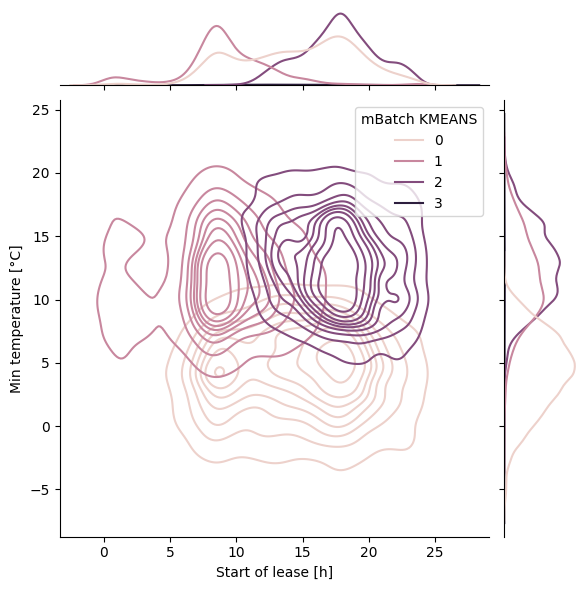

In [32]:
cmap = sns.color_palette("Dark2")
#y="Duration minute f"
sns.jointplot(pred_df[pred_df["Duration minute f"]<100].sample(10000),x="Start hour float",y='tmin',hue="mBatch KMEANS",color="green",kind='kde')
plt.ylabel("Min temperature [°C]")
plt.xlabel("Start of lease [h]")
plt.show()

In [33]:
pre_prophet_df = df.groupby(['Date']).agg(**{'Rental Id_size': ('Rental Id', 'size'), 'Duration_sum': ('Duration', 'sum'),'Duration_avg': ('Duration', 'mean')}).reset_index()

C:\Users\Sztaki\AppData\Local\Temp\ipykernel_18536\1983004497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_df.rename(columns={'Date':'ds','Rental Id_size':'y'},inplace=True)
10:59:10 - cmdstanpy - INFO - Chain [1] start processing
10:59:10 - cmdstanpy - INFO - Chain [1] done processing


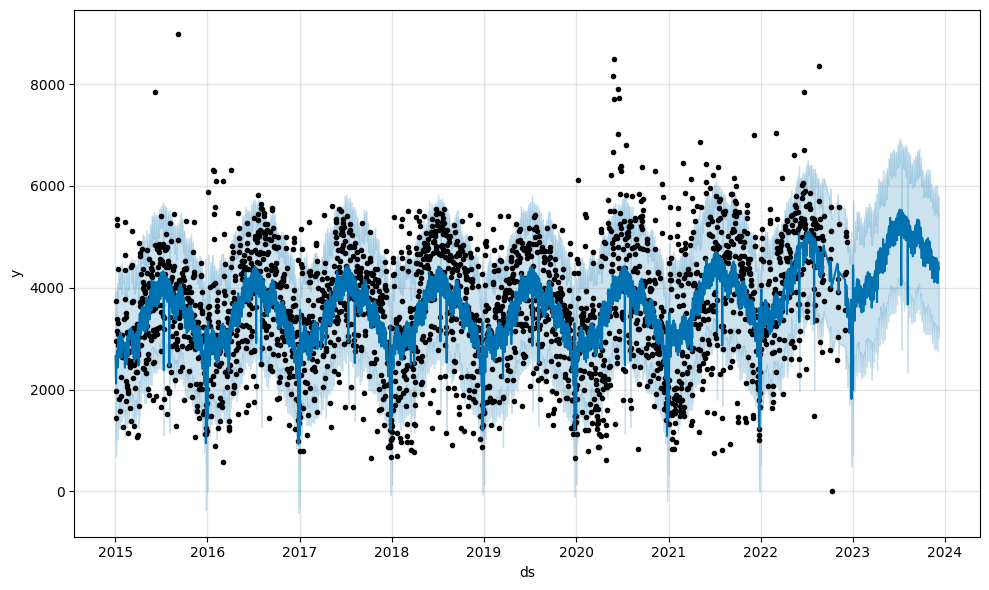

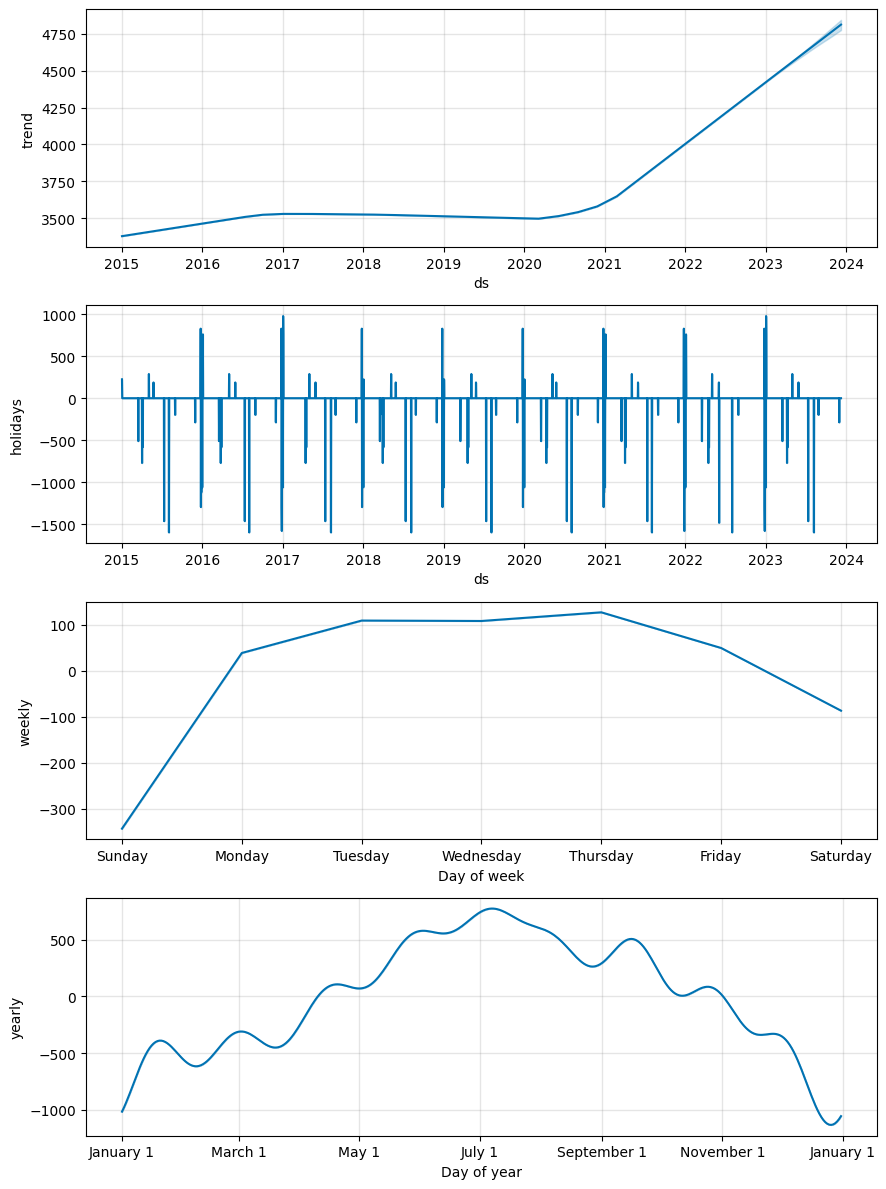

In [34]:
import pandas as pd
from prophet import Prophet

#daily rent estimation
prophet_df = pre_prophet_df[['Date','Rental Id_size']]
prophet_df.rename(columns={'Date':'ds','Rental Id_size':'y'},inplace=True)

m = Prophet()
m.add_country_holidays(country_name='UK')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
